In [2]:
import matplotlib.pyplot as plt
import numpy as np
from astroML import stats as astroMLstats
from sklearn.neighbors import KernelDensity
import scipy.stats as stats
import scipy.integrate
import seaborn as sns
from tqdm import tqdm

## Time to get your hands dirty! The irreducible mass of black holes.

This is an example that comes straight out of my research in general relativity.

**Gerosa, Fabbri, Sperhake (2022) "*The irreducible mass and the horizon area of LIGO's black holes*" [arxiv:2202.08848](https://arxiv.org/abs/2202.08848), [CQG 39 (2022) 175008](https://iopscience.iop.org/article/10.1088/1361-6382/ac8332)**

(some of the calculations here were first worked out by Cecilia Fabbri in her BSc thesis with me).

Consider a rotating black hole. In [1969](https://ui.adsabs.harvard.edu/abs/1969NCimR...1..252P/abstract), Roger Penrose (now [Nobel Prize in Physics](https://www.nobelprize.org/prizes/physics/2020/penrose/facts/) for the theory of black holes) discovered that one can extract energy from a rotating black hole:

![](https://inspirehep.net/files/268d28446b405e134199d84f67c23792)

(figure from [Harada, Kimura 2014](https://ui.adsabs.harvard.edu/abs/2014CQGra..31x3001H/abstract)).\
Maybe some of you has seen this already in your GR class? In any case, a rotating black-hole has a region called ergosphere such that infalling particles have negative energy. Penrose imagined a particle that enters that region and decays: half will fall in and half will escape to infinity, carring some energy with it. In a nutshell, we've extracted energy=mass from a black hole! It turns out that one also has to extract angular momentum, not just energy (and here you'll need some GR do to this calculation, see e.g. the famous textbook by [Misner, Thorne and Weeler](https://press.princeton.edu/books/hardcover/9780691177793/gravitation)). But angular momentum runs our first, such that a repeated series of Penrose processes leaves behind a non-rotating BH with a remnant mass which is called "irreducible". This is a famous result by [Christodoulou 1970](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.25.1596) and is closely related to the even more famous area law by [Hawking (1971)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.26.1344) (which in turns is the foundation of black-hole thermodynamics -- for you, my theorethical physics friend).


For a BH of mass $M$ spin $\chi\in [0,1]$, the irreducible mass is 
\begin{equation}
M_{\rm irr} = %\sqrt{\frac{M^2+\sqrt{M^4-S^2}}{2}} = 
 M \sqrt{\frac{1+\sqrt{1-\chi^2}}{2}}
\label{mirrdef}
\end{equation}
For convenience, let us define 

$$f(\chi) = \sqrt{\frac{1+\sqrt{1-\chi^2}}{2}}$$

Suppose you have repeated measurments of $M$ and $\chi$. This is just because we're still frequentists for now. When we will put our Bayesian hat on, these distributions will be the *posterior samples* from a single measurement.

Let's assume that

- the spin $\chi$ is uniformly distributed between 0 and 1.
- the mass $M$ is normally distributed with mean $\mu$ and standard deviation $\sigma$.
- (masses and spins are uncorrelated)

These are simplistic assumption that, however, are not too far from what we are now measuring with gravitational-wave detectors. It's a toy model, but not a totally unreasonable one.

**Tasks**:

1. Start with a value of $\sigma=0.02$. Note that $\mu$ is a scale and not a parameter: you can normalize all quantities with a dimension of mass by $\mu$. Just set $\mu=1$ in your code and remember that all masses in the problem are measured in units of $\mu$. 

2. Plot the resulting pdf of $M_{\rm irr}$. First try an histogram with one the rules of thumb we've seen above.

*Hint (for point 2)*: You don't know the functional form of the pdf of $M_{\rm irr}$... but you don't need it if you just want to generate samples! That's the nice thing about numerics!

3. Using the same samples, plot the distribution of $M_{\rm irr}$ using a KDE.

4. Compute the KS distance between ${M_{\rm irr}}/\mu$ and ${f}$ as a function of $\sigma$. Discuss the limits at large and small values of $\sigma$. 

5. Compute the KS distance between ${M_{\rm irr}}$ and $M$ as a function of $\sigma$. Discuss the limits at large and small values of $\sigma$.

*Hint (for points 4 and 5)*. This is a KS test between two sets for samples, `scipy.stats.ks_2samp`.

You should find that (i) $M_{\rm irr}$ is distributed like $f$ if ${\sigma}\ll \mu$ and (ii) $M_{\rm irr}$ is distributed like $M$ if  $\sigma\gg \mu$.


7. [**Optional, not examinable**] Compute the pdf of $f$ from its mathematical definition (pen and paper!). Verify this result: 

\begin{equation}
\pi(f) = 2\frac{2 f^2-1}{\sqrt{1 - f^2}}\,.
\end{equation}

8. [**Optional, not examinable**]  Compute the pdfs of $M_{\rm irr}$ from its mathematical definition (pen and paper!). Verify this result:

\begin{equation}
p(M_{\rm irr})  = \frac{\sqrt{2/\pi}}{\sigma} \int_{1/\sqrt{2}}^1 \exp\left[{-\frac{(M_{\rm irr}/f -\mu)^2}{2\sigma^2}}\right]  \frac{2 f^2-1}{f \sqrt{1 - f^2}}  \,\, {\rm d}f\,. \label{pmirr}
\end{equation}

The this expression is only semi-analytic; that integral should then be solved numerically.

*Hint (for point 8)*: You want to use [this theorem](https://en.wikipedia.org/wiki/Distribution_of_the_product_of_two_random_variables) for the product of two random variables. 

9. Using the expressions from point 7 and 8, plot those pdfs check that they agree with your KDE reconstructions.


In [3]:
def f (chi):
    return ((1+(1-chi**2)**0.5)/2)**0.5

def pdf_f (f):
    return 2*(2*f**2-1)/(1 - f**2)**0.5

def pdf_M (M, mu, sigma):  #mass distribution
    return stats.norm.pdf(M, mu, sigma)

In [4]:
mu = 1
sigma = 0.02
n = 10000 #number of samples

/var/folders/dm/sy7c98fx7rl_tb_zs0mdpsj40000gn/T/ipykernel_38095/78057998.py:5: RuntimeWarning: invalid value encountered in sqrt
  return 2*(2*f**2-1)/(1 - f**2)**0.5


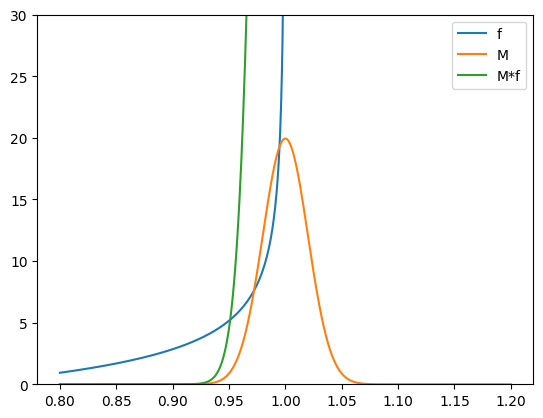

In [5]:
x = np.linspace(0.8, 1.2, 1000)
plt.plot(x, pdf_f(x), label='f')
plt.plot(x, pdf_M(x, mu, sigma), label='M')
plt.plot(x, pdf_M(x, mu, sigma)*pdf_f(x), label='M*f')  
plt.ylim(0, 30)
plt.legend()

In [6]:
M = np.random.normal(mu, sigma, size = n)
chi = np.random.uniform(0,1, size = n)
M_irr = M * f(chi #(masses and spins are uncorrelated)

## binning with Freedman-Diaconis rule

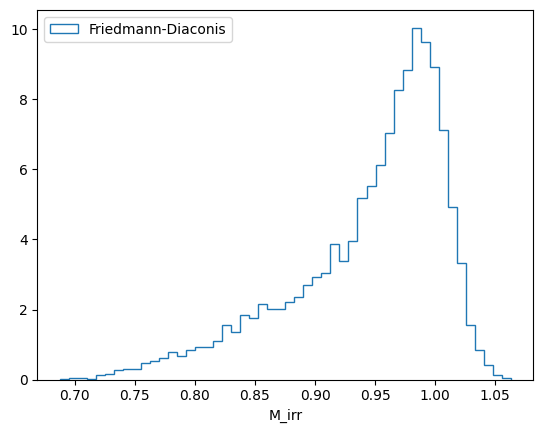

In [7]:
sigmaG = astroMLstats.sigmaG(M_irr)
binsize = 2.7*sigmaG/(n**(1/3))
#print(max(M_irr), min(M_irr))
n_bins = int((max(M_irr)-min(M_irr))/binsize)

plt.hist(M_irr, bins = n_bins, density = True, histtype= 'step', label='Friedmann-Diaconis');
plt.xlabel('M_irr')
plt.legend()

## binning with Scott's rule

Text(0.5, 0, 'M_irr')

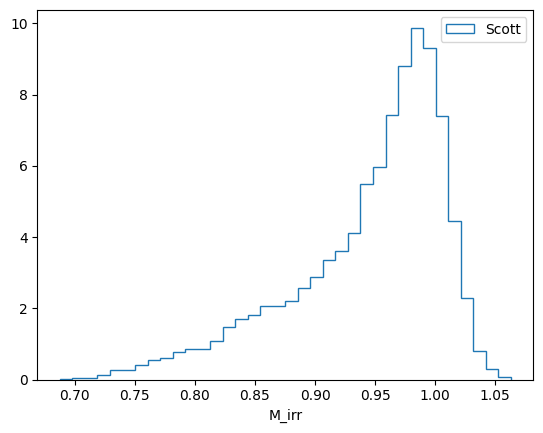

In [9]:
sigma = np.std(M_irr)
binsize = 3.5*sigma/(n**(1/3))
n_bins_scott = int((max(M_irr)-min(M_irr))/binsize)
plt.hist(M_irr, bins = n_bins_scott, density = True, histtype= 'step', label= 'Scott');
plt.legend()
plt.xlabel('M_irr')

## now using KDE

In [10]:
xgrid = np.linspace(M_irr.min(),M_irr.max(),1000)

def kde_sklearn(data, bandwidth = 1.0, kernel="linear"):
    kde_skl = KernelDensity(bandwidth = bandwidth, 
                            kernel=kernel)
    kde_skl.fit(data[:, np.newaxis])
    log_pdf = kde_skl.score_samples(xgrid[:, np.newaxis]) 

    return np.exp(log_pdf)

Text(0.5, 0, 'M_irr')

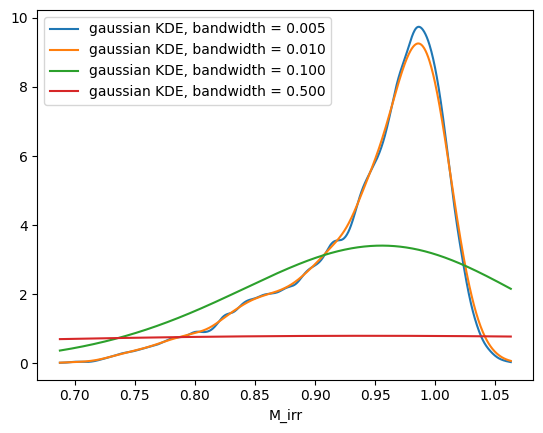

In [11]:
bandwidths = [0.005, 0.01, 0.1, 0.5]
for bandwidth in bandwidths:
    pdf = kde_sklearn(M_irr, bandwidth = bandwidth, kernel = 'gaussian')
    plt.plot(xgrid, pdf, label='gaussian KDE, bandwidth = %.3f' % bandwidth)

plt.legend()
plt.xlabel('M_irr')

Text(0.5, 0, 'M_irr')

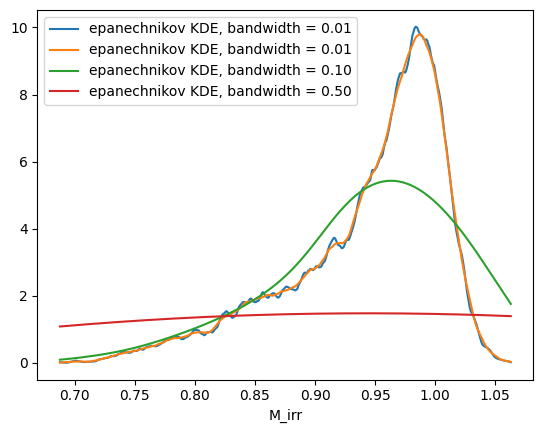

In [12]:
bandwidths = [0.005, 0.01, 0.1, 0.5]
for bandwidth in bandwidths:
    pdf = kde_sklearn(M_irr, bandwidth = bandwidth, kernel = 'epanechnikov')
    plt.plot(xgrid, pdf, label='epanechnikov KDE, bandwidth = %.2f' % bandwidth)

plt.legend()
plt.xlabel('M_irr')

## Computing the KS distance


00%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  8.32it/s]

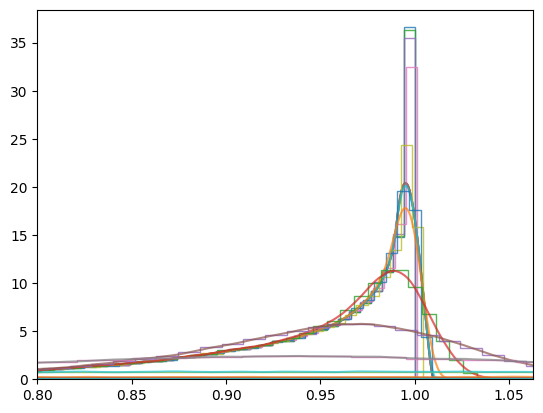

In [15]:
# I want to study the Kolmogov-Smirnov distance in function of sigma


n_draws = 100000
sigmas = np.logspace(-5,5, 20)
bandwidth = 0.01

KS_distance_from_f = []
KS_distance_from_M = []

chi = np.random.uniform(0, 1, size = n_draws)
f_chi = f(chi)

for sigma_i in tqdm(sigmas):
    M = np.random.normal(mu, sigma_i, size = n_draws )
    M_irr = M * f_chi
    plt.hist(M_irr, bins = n_bins, density = True, histtype= 'step',alpha= 0.8);
    pdf = kde_sklearn(M_irr, bandwidth, kernel = 'epanechnikov')

    KS_distance_from_f.append(stats.ks_2samp(M_irr, f_chi))
    KS_distance_from_M.append(stats.ks_2samp(M_irr, M))

    plt.plot(xgrid, pdf, label='sigma = %.3f' % sigma_i, alpha= 0.7)

plt.xlim(0.8,xgrid.max())

KS_distance_from_f = np.array(KS_distance_from_f)
KS_distance_from_M = np.array(KS_distance_from_M)  

$M_{\rm irr}$ is distributed like $f$ if ${\sigma}\ll \mu$ and $M_{\rm irr}$ is distributed like $M$ if  $\sigma\gg \mu$.

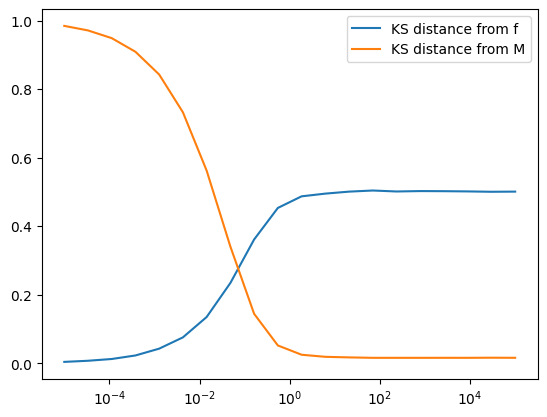

In [16]:
plt.plot(sigmas, KS_distance_from_f[:,0], label = 'KS distance from f')
plt.plot(sigmas, KS_distance_from_M[:,0], label = 'KS distance from M' )
plt.xscale('log')
plt.legend()